In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train_dir = '/mnt/d/machinelearning/plant_image_classifiaction/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/mnt/d/machinelearning/plant_image_classifiaction/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/mnt/d/machinelearning/plant_image_classifiaction/test/test'

In [3]:
from collections import Counter
def plot(generator, title):
    class_indices = generator.class_indices
    labels = list(class_indices.keys())
    counts = dict(Counter(generator.classes))

    plt.figure(figsize=(10,5))
    plt.bar(range(len(counts)), list(counts.values()), tick_label = labels)
    plt.title(title)
    plt.xlabel('classes')
    plt.ylabel('no. of images')
    plt.xticks(rotation=90)
    plt.show()

In [7]:
import tensorflow as tf

# Use image_dataset_from_directory without class_mode
train_gen = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',   # Automatically infers the class labels
    batch_size=32,
    image_size=(128, 128),  # Adjust image size as needed
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,  # If you want to use validation split, set subset to 'training' or 'validation'
    interpolation='bilinear',
    follow_links=False
)

# Example for validation generator (if needed)
valid_gen = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels='inferred',   # Automatically infers the class labels
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels='inferred',   # Automatically infers the class labels
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)


Found 70294 files belonging to 38 classes.


I0000 00:00:1729267101.840651     617 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729267102.240970     617 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729267102.241031     617 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729267102.245059     617 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729267102.245125     617 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 17572 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [10]:
# Convert class names to a dictionary where index is the key, and class name is the value
class_dict = {i: class_name for i, class_name in enumerate(train_gen.class_names)}

print(class_dict)


{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'To

In [1]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, Multiply, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer
import tensorflow as tf

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = Conv2D(1, kernel_size=self.kernel_size, strides=1, padding='same', activation='sigmoid')

    def call(self, input_feature):
        avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return Multiply()([input_feature, attention])

    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        config.update({
            'kernel_size': self.kernel_size
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Load the VGG16 base model without global pooling
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model

# Apply Spatial Attention after the base model's output
x = base_model.output
x = SpatialAttention()(x)  # Apply custom spatial attention to the feature map

# Global Average Pooling after attention
x = GlobalAveragePooling2D()(x)

# Flatten and add Dense Layers
x = Dense(512, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)  # Add Dropout to prevent overfitting

# Final output layer
# num_classes = len(train_gen.class_indices)  # Number of output classes
output = Dense(38, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


2024-10-18 20:54:06.327758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 20:54:06.357537: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 20:54:06.366637: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 20:54:06.386948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 20:54:08.010685: W tensorflow/compiler/tf2

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        960 │ block1a_se_excit

 Total params: 11,590,072 (44.21 MB)

 Trainable params: 806,537 (3.08 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.252205 to fit



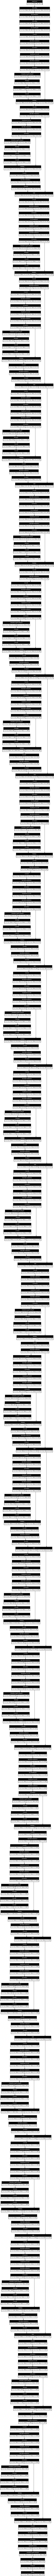

In [3]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='efficientnetb3.png')

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

# Define the callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,         # Lower bound on the learning rate
    verbose=1            # Verbosity mode
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored quantity
)

# Fit the model with the callbacks
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    # steps_per_epoch=len(train_gen),
    # validation_steps=len(valid_gen),
    callbacks=[reduce_lr, early_stopping]  # Add the callbacks here
)


Epoch 1/100


I0000 00:00:1729260416.425409    1049 service.cc:146] XLA service 0x7fc4b4077df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729260416.425456    1049 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-18 19:36:57.008435: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-18 19:36:59.316768: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-18 19:37:03.263527: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18824', 144 bytes spill stores, 144 bytes spill loads

2024-10-18 19:37:04.241327: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in fun

2196/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5125 - loss: 1.8769

2024-10-18 19:43:22.891033: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18824', 12 bytes spill stores, 12 bytes spill loads

2024-10-18 19:43:22.904102: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18824', 172 bytes spill stores, 172 bytes spill loads

2024-10-18 19:43:23.833220: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19822', 24 bytes spill stores, 24 bytes spill loads

2024-10-18 19:43:24.444978: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19820', 12 bytes spill stores, 12 bytes spill loads

2024-10-18 19:43:24.503298: I external/local_xla/xla/s

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 464s 192ms/step - accuracy: 0.5126 - loss: 1.8763 - val_accuracy: 0.8708 - val_loss: 0.4717 - learning_rate: 1.0000e-04
Epoch 2/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 95s 43ms/step - accuracy: 0.8186 - loss: 0.6077 - val_accuracy: 0.9051 - val_loss: 0.3353 - learning_rate: 1.0000e-04
Epoch 3/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 66s 30ms/step - accuracy: 0.8564 - loss: 0.4615 - val_accuracy: 0.9201 - val_loss: 0.2739 - learning_rate: 1.0000e-04
Epoch 4/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 66s 30ms/step - accuracy: 0.8804 - loss: 0.3846 - val_accuracy: 0.9281 - val_loss: 0.2400 - learning_rate: 1.0000e-04
Epoch 5/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 66s 30ms/step - accuracy: 0.8914 - loss: 0.3410 - val_accuracy: 0.9358 - val_loss: 0.2126 - learning_rate: 1.0000e-04
Epoch 6/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 66s 30ms/step - accuracy: 0.9055 - loss: 0.2994 - val_accuracy: 0.9429 - val_loss: 0.1903 - learning_rate: 1.0000e-04
Epoch 7/100
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6

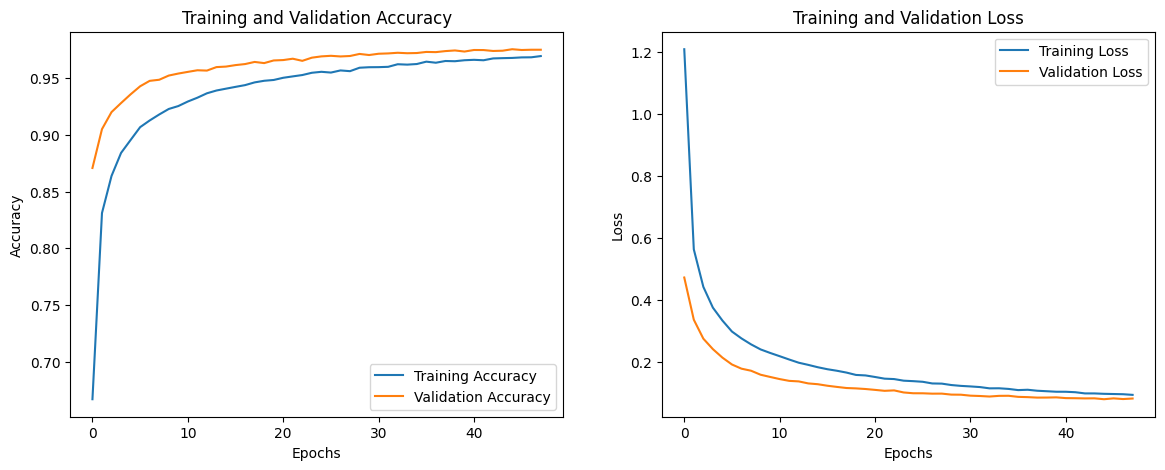

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plotting training & validation accuracy and loss
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(14, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call this function after training
plot_training_history(history)

550/550 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step


2024-10-18 20:36:57.760479: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


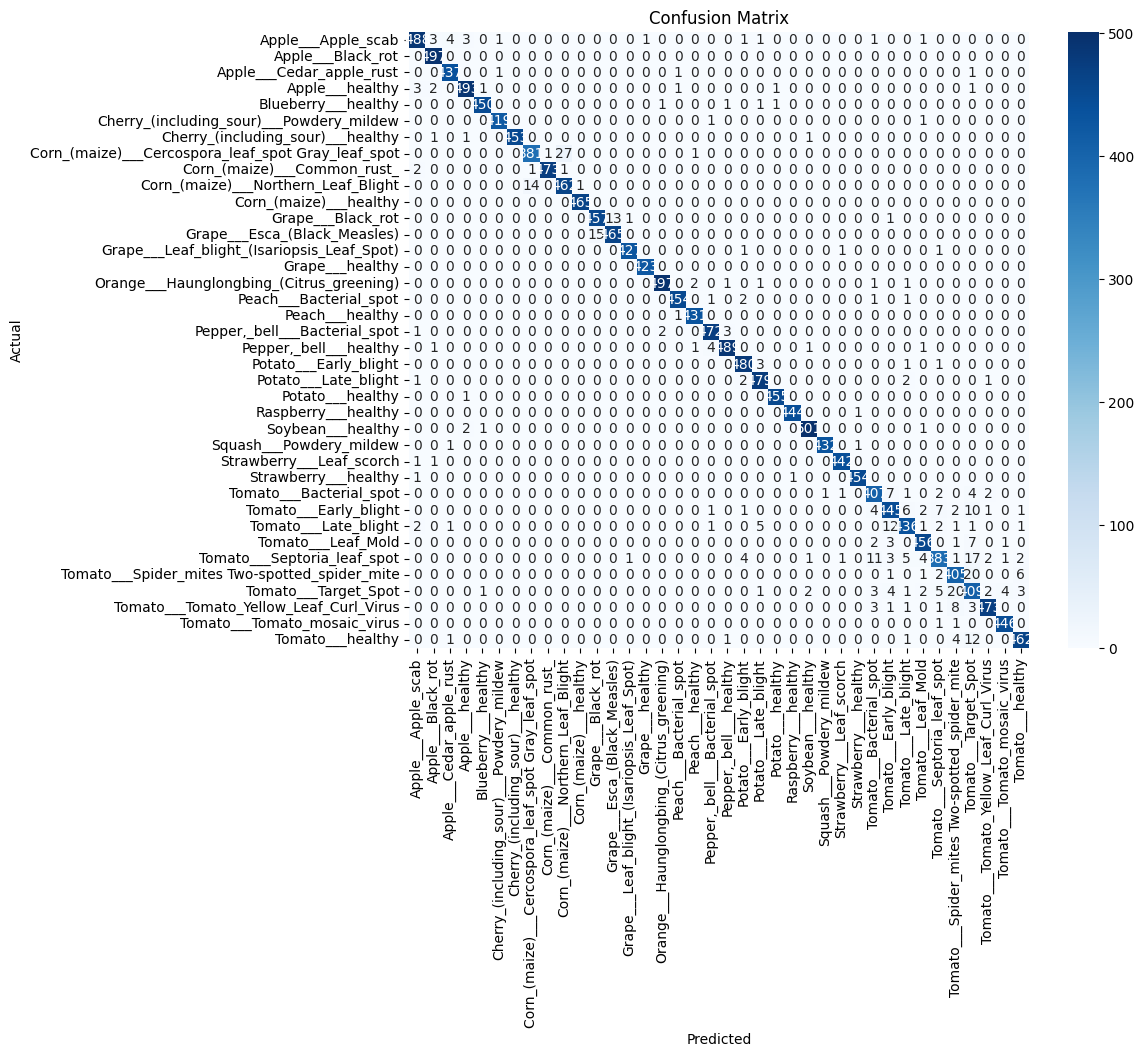

Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.97      0.97       504
                                 Apple___Black_rot       0.98      1.00      0.99       497
                          Apple___Cedar_apple_rust       0.98      0.99      0.99       440
                                   Apple___healthy       0.99      0.98      0.98       502
                               Blueberry___healthy       0.99      0.99      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.93      0.95       410
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight     

In [8]:
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)  # Convert from one-hot encoded output to class index

# Get true labels from the test generator
true_classes = np.concatenate([y for x, y in test_gen], axis=0)

# Check if true_classes are one-hot encoded or integer encoded
if true_classes.ndim > 1:
    # If the labels are one-hot encoded, convert them to class index
    true_classes = np.argmax(true_classes, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_names, yticklabels=test_gen.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(true_classes, predicted_classes, target_names=test_gen.class_names)
print('Classification Report:\n', class_report)

In [9]:
model.save('ResNet_1.keras')

In [11]:
from tensorflow.keras.models import load_model

# Ensure you register the custom layer when loading
model = load_model('ResNet_1.keras', custom_objects={'SpatialAttention': SpatialAttention})


/home/ronak/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'spatial_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/ronak/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 18 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/ronak/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(

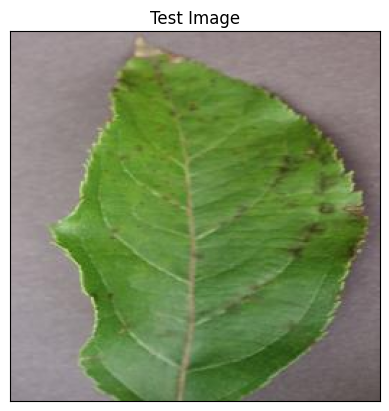

In [12]:
import cv2
image_path = './test/test/Apple__Apple_scab/AppleScab1.JPG'
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [13]:
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128,128))
input_array = tf.keras.preprocessing.image.img_to_array(image)
input_array = np.array([input_array])

In [14]:
prediction = model.predict(input_array)
prediction

2024-10-18 20:38:29.903777: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng53{k2=5,k13=1,k14=2,k18=1,k23=0} for conv (f32[1,96,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,288,8,8]{3,2,1,0}, f32[96,288,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-18 20:38:29.904900: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.719304544s
Trying algorithm eng53{k2=5,k13=1,k14=2,k18=1,k23=0} for conv (f32[1,96,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,288,8,8]{3,2,1,0}, f32[96,288,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wai

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


array([[4.6819779e-01, 1.6002104e-03, 1.1244770e-01, 2.1371845e-05,
        1.4400051e-04, 3.9597696e-01, 2.1910578e-08, 4.8554150e-05,
        3.9446698e-07, 6.6867608e-05, 1.2932291e-07, 5.5247592e-06,
        3.7962911e-07, 3.5328021e-08, 1.5437783e-09, 4.2715986e-04,
        8.0234669e-03, 7.3957374e-08, 3.2778836e-03, 4.0411991e-03,
        4.7660437e-06, 4.0898045e-05, 1.1189271e-06, 3.8512011e-09,
        6.3741808e-08, 2.8974543e-07, 2.6657377e-08, 4.9124498e-08,
        5.3373091e-03, 1.2569332e-04, 2.0681173e-04, 1.1423677e-08,
        9.7347379e-07, 4.7133702e-10, 2.3596584e-07, 2.0854570e-06,
        9.4353625e-10, 4.6641924e-10]], dtype=float32)

In [15]:
results = np.argmax(prediction)

In [16]:
import os
test_dir = '/mnt/d/machinelearning/plant_image_classifiaction/test/test'
class_name = os.listdir(test_dir)

In [17]:
model_prediction = class_name[results]
print(model_prediction)

Apple__Apple_scab
